In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
Mfail = pd.read_csv("machine_failure_dataset.csv")

# Entendimiento del problema

El dataset esta diseñado para predecir el riesgo de fallas de máquinas en entornos de fabricación industrial, utilizando datos de sensores en tiempo real de varios tipos de maquinaria. Incluye 1000 muestras que representan diferentes intervalos de tiempo de funcionamiento, y cada muestra proporciona mediciones clave de sensores relevantes para el monitoreo del estado de la máquinaria y el mantenimiento predictivo.

## Caracteristicas de los datos

Temperature (°C): Datos continuos que representan la temperatura en los puntos criticos de la máquina. \
Nota: Las temperaturas altas pueden indicar problemas por sobrecalentamiento.

Vibration (Hz): Frecuencia de las vibraciones. \
Nota: Las vibraciones anormales pueden indicar desalineación mecánica, desequilibrio o desgaste.

Power Usage (kW): Niveles  del consumo de energía de la máquina.\
Nota: Los picos en el uso de enrgía pueden indicar una mayor carga o posibles problemas mecánicos.

Humidity (%): Humedad ambiental alrededor de la maquina. \
Nota: Los altos niveles de humedad podrían afectar el rendimiento de la máquina y provocar fallas con el tiempo.

Machine Type: Datos categóricos que indican el tipo de máquina (e.g., "Drill", "Lathe", "Mill"). \
Nota: Los diferentes tipos de máquinas pueden tener patrones de falla únicos.

Failure Risk: Es una etiqueta binaria donde 0 indica un funcionamiento normal y 1 indica que la máquina corre el riesgo de fallar.



## Pregunta a resolver

- Desarrollar un modelo predictivo que ayude a detectar fallas 
- Explorar tendencias en la lectura de sensores asociadas con eventos de falla 
- Comprender el impacto de diferentes características en el estado de la máquina

# Exploración inicial de datos (EDA)

In [3]:
Mfail.head()

,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
0,74.967142,56.996777,8.649643,20.460962,Mill,1
1,68.617357,54.623168,9.710963,25.698075,Lathe,0
2,76.476885,50.298152,8.415160,27.931972,Drill,1
3,85.230299,46.765316,9.384077,39.438438,Lathe,1
4,67.658466,53.491117,6.212771,32.782766,Drill,1


In [4]:
Mfail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   1000 non-null   float64
 1   Vibration     1000 non-null   float64
 2   Power_Usage   1000 non-null   float64
 3   Humidity      1000 non-null   float64
 4   Machine_Type  1000 non-null   object 
 5   Failure_Risk  1000 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


En este set de datos podemos encontrar datos flotantes, enteros y objetos dentro de 6 columnas. Algo que ya se esperaba tomando en cuenta la descripción acerca del dataset, sin embargo, se observa que no existen valores nulos dentro del mismo.

In [5]:
Mfail.describe()

,Temperature,Vibration,Power_Usage,Humidity,Failure_Risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,70.193321,50.354181,10.011668,29.906404,0.300000
std,9.792159,4.987272,1.966909,5.135663,0.458487
min,37.587327,35.298057,3.960976,15.352757,0.000000
25%,63.524097,46.968792,8.704001,26.312898,0.000000
50%,70.253006,50.315386,9.999498,30.000923,0.000000
75%,76.479439,53.644411,11.321831,33.334727,1.000000
max,108.527315,65.965538,17.852475,46.215465,1.000000


En un análisis rápido, se logra observar que existen outliers en las columnas: Temperature, Vibration, Power_Usage y Humidity. Esto se puede ser causado cuando alguna de las maquinas presenta alguna falla. Por otro lado, observando la media de Failure_Risk (0.300000) se llego a la conclusión de que la probabilidad de que ocurra una falla es del 30%.

## Detección de Outliers

En esta parte se va a analizar si los Outliers son relevantes, o si es posible eliminarlos para un mejor analisis.

In [6]:
def detec_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5*IQR
    lim_sup = Q3 + 1.5*IQR
    
    outliers = df[(df[column] < lim_inf) | (df[column] > lim_sup)]
    return outliers


In [7]:
for col in Mfail.select_dtypes(include="float64").columns:
    outliers = detec_outliers(Mfail, col)
    print(f"Outliers en {col}: {len(outliers)} valores")

Outliers en Temperature: 8 valores
Outliers en Vibration: 8 valores
Outliers en Power_Usage: 10 valores
Outliers en Humidity: 5 valores


In [8]:
for col in Mfail.select_dtypes(include="float64").columns:
    outliers = detec_outliers(Mfail, col)
    print(f"\nOutliers en {col}:")
    print(outliers[[col]])  # Mostrar solo la columna con outliers




Outliers en Temperature:
     Temperature
74     43.802549
179    97.201692
209   108.527315
262    37.587327
478   100.788808
646    43.031134
668    43.490302
755    96.323821

Outliers en Vibration:
     Vibration
61   35.757287
101  35.518723
539  35.638689
591  35.393248
615  65.965538
750  36.483839
957  65.688743
971  35.298057

Outliers en Power_Usage:
     Power_Usage
24      3.960976
35     15.519320
305    16.219837
506    15.898189
521    15.970518
556     4.728505
801    15.386067
884     4.504990
895    17.852475
947     4.017728

Outliers en Humidity:
      Humidity
152  15.465059
241  44.342015
454  15.352757
716  46.215465
982  45.760284


In [9]:
for col in Mfail.select_dtypes(include="float64").columns:
    outliers = detec_outliers(Mfail, col)
    print(f"\nOutliers en {col} (Total: {len(outliers)})")
    print(outliers)  # Mostrar todas las columnas de las filas con outliers



Outliers en Temperature (Total: 8)
     Temperature  Vibration  Power_Usage   Humidity Machine_Type  Failure_Risk
74     43.802549  54.981334     8.764696  26.334835        Lathe             0
179    97.201692  44.482053    10.013600  32.578140         Mill             1
209   108.527315  58.747884     9.998583  32.256127         Mill             0
262    37.587327  52.693780    12.471564  25.476928        Drill             1
478   100.788808  45.562539     7.322788  35.767952        Lathe             0
646    43.031134  49.064279     9.258984  31.293306        Lathe             0
668    43.490302  54.203100    11.104600  29.289267        Drill             1
755    96.323821  56.868293     9.096681  20.155384         Mill             0

Outliers en Vibration (Total: 8)
     Temperature  Vibration  Power_Usage   Humidity Machine_Type  Failure_Risk
61     68.143410  35.757287     9.725256  28.335698         Mill             0
101    65.793547  35.518723     8.195897  34.277778         M

En estos outliers se encuentra información algo util, ya que existen datos donde la maquina falla y es suficiente para no quitarlos del analisis aunque por si solos no nos dan un analisis contundente.

# Análisis univariado

## Variables númericas

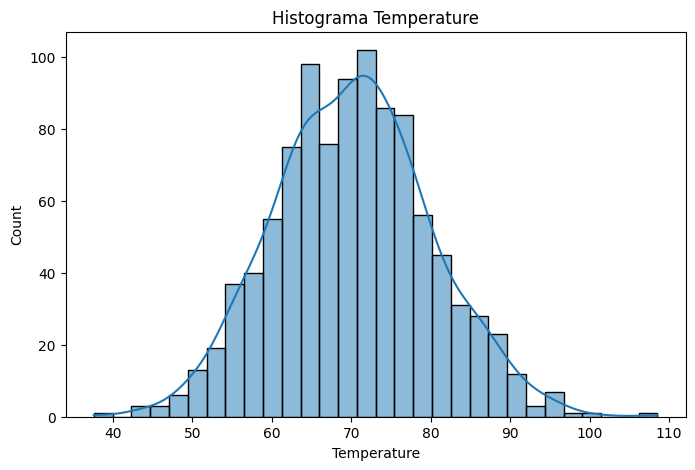

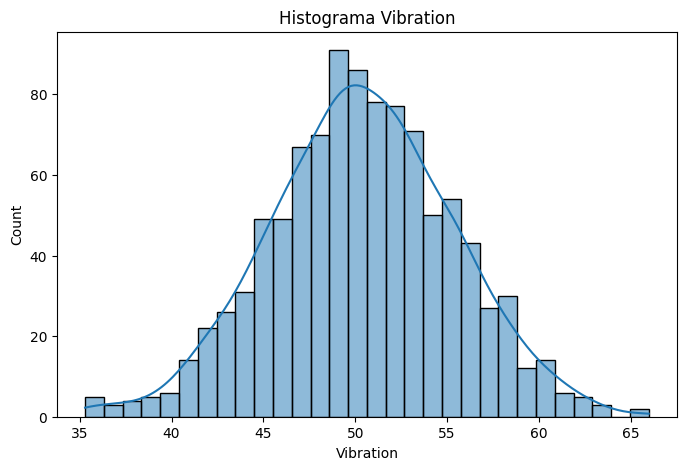

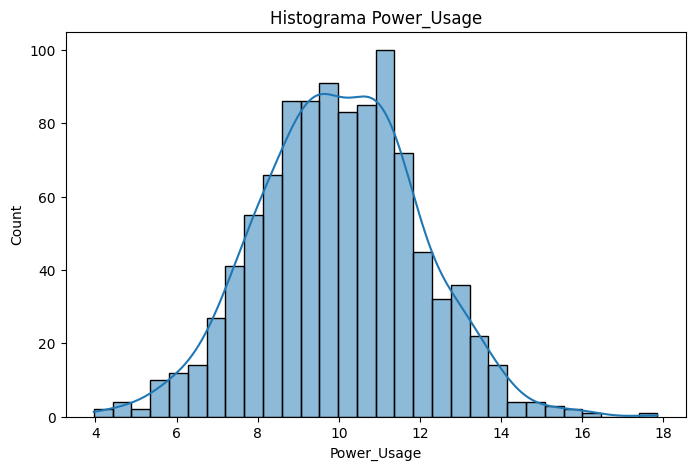

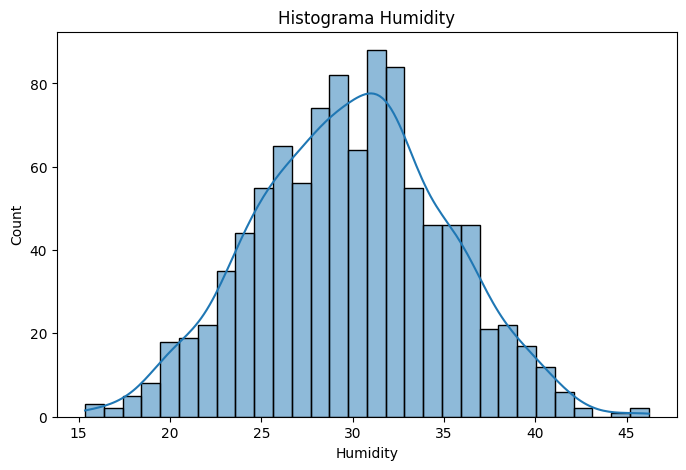

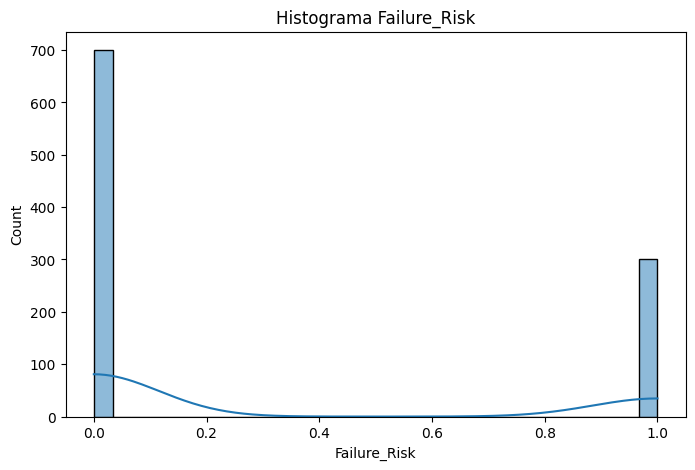

In [10]:
for caracteristica in Mfail.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(Mfail[caracteristica], bins=30, kde=True)
    plt.title(f"Histograma {caracteristica}")
    plt.xlabel(caracteristica)
    plt.show()

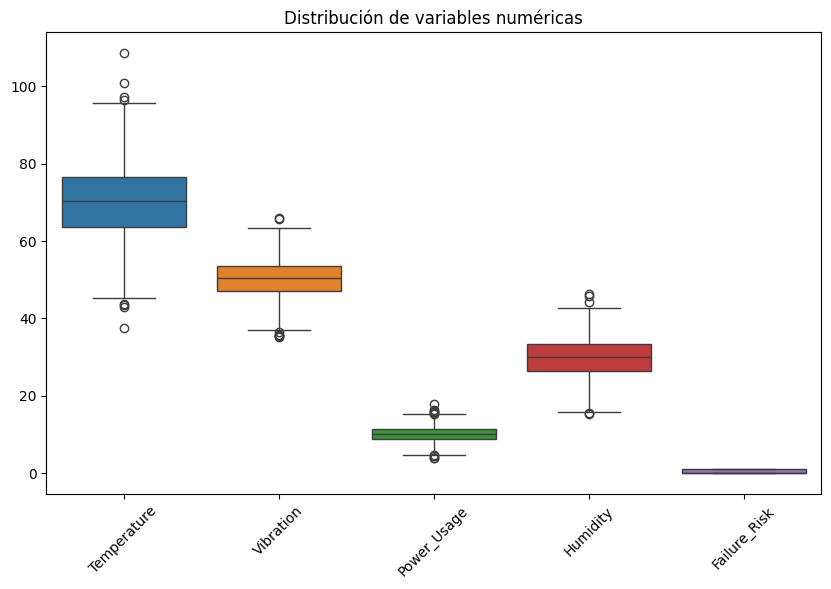

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=Mfail.select_dtypes(include=["float64", "int64"]))
plt.xticks(rotation=45)
plt.title("Distribución de variables numéricas")
plt.show()


# Análisis Bivariado

Primero vamos a considerar columnas numéricas, esto para evitar errores.

In [12]:
Col_numericas = Mfail.select_dtypes(include=["float64","int64"])
Col_numericas

,Temperature,Vibration,Power_Usage,Humidity,Failure_Risk
0,74.967142,56.996777,8.649643,20.460962,1
1,68.617357,54.623168,9.710963,25.698075,0
2,76.476885,50.298152,8.415160,27.931972,1
3,85.230299,46.765316,9.384077,39.438438,1
4,67.658466,53.491117,6.212771,32.782766,1
...,...,...,...,...,...
995,67.188997,55.350751,10.154961,30.142288,1
996,87.976865,49.867394,10.515505,19.610941,0
997,76.408429,45.590627,7.516479,28.398511,0
998,64.288210,49.184665,10.668353,38.216891,1


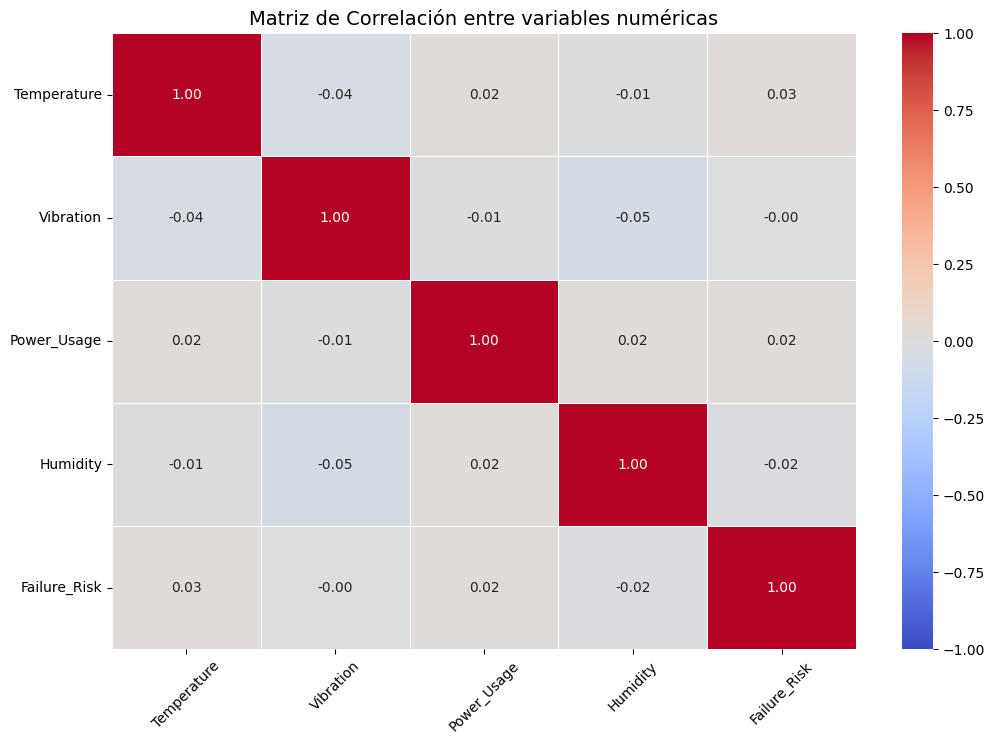

In [13]:
plt.figure(figsize=(12, 8))
matriz_correlacion = Col_numericas.corr()
sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Matriz de Correlación entre variables numéricas", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Variables con mayor correlación

In [14]:
pares_Cor = matriz_correlacion.unstack().sort_values(ascending=False) # Con esto obtengo los pares de correlación obasoluta de modo ordenado

correlaciones = pares_Cor[(pares_Cor < 1) & (pares_Cor > 0.6)] #Esto solo filta correlaciones altas

print(correlaciones)


Series([], dtype: float64)


Lo anterior nos dice que las variables que tenemos no tienen una relación lineal, pero podrian tener una relación de otro tipo. Por lo tanto voy a usar las correlaciones Spearman, kendell y graficos de dispersión para encontrar otro tipo de relación.

# Correlación de Spearman

Para poder usar la correlación de Spearman, voy a usar Label Encoding para transformar "Machine Type" en valores númericos.

In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
if "Machine_Type" in Mfail.columns:  # Verificar que la columna exista
    Mfail["Machine_Type"] = encoder.fit_transform(Mfail["Machine_Type"])



In [16]:
print(Mfail.dtypes)

Temperature     float64
Vibration       float64
Power_Usage     float64
Humidity        float64
Machine_Type      int32
Failure_Risk      int64
dtype: object


In [17]:
Mfail.corr(method='spearman')

,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
Temperature,1.000000,-0.063765,0.036477,-0.004736,-0.001476,0.038643
Vibration,-0.063765,1.000000,-0.009203,-0.055589,0.050870,-0.005405
Power_Usage,0.036477,-0.009203,1.000000,0.027426,-0.046736,0.021529
Humidity,-0.004736,-0.055589,0.027426,1.000000,-0.010524,-0.014083
Machine_Type,-0.001476,0.050870,-0.046736,-0.010524,1.000000,-0.029996
Failure_Risk,0.038643,-0.005405,0.021529,-0.014083,-0.029996,1.000000


Utilizando la correlación de Spearman observamos que no existe relacion alguna, por lo tanto pasaremos a utilizar la siguiente correlación, la correlacion de Kendall

In [18]:
Mfail.corr(method='kendall')

,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
Temperature,1.000000,-0.043828,0.023916,-0.003584,-0.000711,0.031568
Vibration,-0.043828,1.000000,-0.006266,-0.036889,0.039267,-0.004415
Power_Usage,0.023916,-0.006266,1.000000,0.018659,-0.035958,0.017587
Humidity,-0.003584,-0.036889,0.018659,1.000000,-0.007725,-0.011504
Machine_Type,-0.000711,0.039267,-0.035958,-0.007725,1.000000,-0.028280
Failure_Risk,0.031568,-0.004415,0.017587,-0.011504,-0.028280,1.000000


En vista de que con este metodo no se encontro ninguna relación, pasare a la opción de utilizar algun modelo de machine learning para encontrar alguna relación en el modelo.

## Pruebas de modelos


# Random Forest

In [19]:
from sklearn.preprocessing import LabelEncoder
#Esta libreria se usa para convertir los datos categoricos de "Machine_Type" en datos númericos

In [20]:
#Esto es para convertir las diferentes variables de "Machine_Type" en variables numericas
encoder = LabelEncoder()
Mfail["Machine_Type"] = encoder.fit_transform(Mfail["Machine_Type"])
print(Mfail["Machine_Type"].value_counts())

Machine_Type
1    338
0    334
2    328
Name: count, dtype: int64


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [22]:
X = Mfail.drop(columns=['Failure_Risk']) #Aqui se toman todos los valores del dataset, con excepción de la columna Failure_Risk
y = Mfail['Failure_Risk']

In [23]:
#Aquí se dividen las variables de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#Ahora se crea el modelo de entrenamiento
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [25]:
# Hacer predicciones
y_pred = clf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Mostrar importancia de variables
importances = pd.Series(clf.feature_importances_, index=X.columns)
print("\nImportancia de características:")
print(importances.sort_values(ascending=False))


Precisión: 0.63
              precision    recall  f1-score   support

           0       0.66      0.91      0.77       135
           1       0.20      0.05      0.07        65

    accuracy                           0.63       200
   macro avg       0.43      0.48      0.42       200
weighted avg       0.51      0.63      0.54       200


Importancia de características:
Temperature     0.240728
Vibration       0.238186
Humidity        0.236708
Power_Usage     0.233204
Machine_Type    0.051172
dtype: float64


## Codigo probando SMOTE(Oversampling)

In [26]:
from imblearn.over_sampling import SMOTE


# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Dividir datos balanceados en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Hacer predicciones
y_pred = clf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Importancia de variables
importances = pd.Series(clf.feature_importances_, index=X.columns)
print("\nImportancia de características:")
print(importances.sort_values(ascending=False))


Precisión: 0.69
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       148
           1       0.66      0.71      0.68       132

    accuracy                           0.69       280
   macro avg       0.69      0.69      0.69       280
weighted avg       0.69      0.69      0.69       280


Importancia de características:
Vibration       0.247316
Temperature     0.242323
Power_Usage     0.228276
Humidity        0.225325
Machine_Type    0.056759
dtype: float64


## Posible uso

Un posible uso para este modelo puede ser utilizarlo para predecir observaciones en tiempo real

Predicción usando probabilidades

In [27]:
import os
os.getcwd()


'C:\\Users\\Farsa\\DataSets\\Machine failure Classification using sensor'